In [1]:
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
import numpy as np
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

import warnings
warnings.filterwarnings("ignore")

C:\Users\strub\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [2]:
number = 10
file = 'OLYMP_'+str(number)+'.csv'

df_a = pd.read_csv(file)
df_a['y'] = df_a['y'].astype(float)
del(df_a['value'])
df_a.head()
#len(df_a)

,group,time_idx,y
0,9,0,350.0
1,9,1,422.0
2,9,2,394.0
3,9,3,297.0
4,9,4,288.0


In [3]:
from pytorch_forecasting import TimeSeriesDataSet

max_encoder_length=len(df_a)-30  # This is the lookbackwindow
print(max_encoder_length)
max_prediction_length=30 # This is the prediction window / horizon 

training_cutoff = df_a["time_idx"].max() - max_prediction_length
print(training_cutoff)

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
    df_a,
    group_ids=["group"],
    target="y",
    time_idx="time_idx",
    #min_encoder_length=200,
    max_encoder_length=max_encoder_length,
    #min_prediction_length=50,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["y"],
)

validation = TimeSeriesDataSet.from_dataset(training, df_a, min_prediction_idx=training_cutoff + 1)
batch_size = 1024 # Aus dem Paper 
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

1230
1229


In [4]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print(SMAPE()(baseline_predictions, actuals))
(actuals - baseline_predictions).abs().mean()

tensor(0.6783)


tensor(1446.9000)

In [5]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
pl.seed_everything(42)

trainer = pl.Trainer(
    max_epochs=5000, #iterations in N-Beats Paper = 5.000 
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],# Model hört auf zu lernen, wenn es sich nicht weiter verbessert
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=0.001, # Aud dem Paper
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512], # aus N-Beats Tutorial 
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 3.6 M 
-----------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.551    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [7]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [8]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [9]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
print(SMAPE()(predictions, actuals))
(actuals - predictions).abs().mean()

tensor(0.2355)


tensor(503.3562)

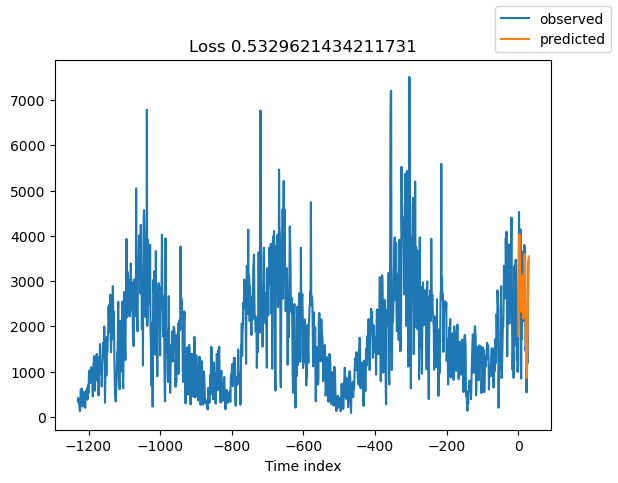

In [10]:
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [11]:
x_value=raw_predictions.prediction
x=x_value.cpu().detach().numpy()
prediction=np.reshape(x,(30,))
print(len(prediction))


30


In [12]:
from datetime import datetime, date, timedelta

days = 15*(number-1)
a = pd.to_datetime('2021-01-01')+timedelta(days=days)
b = pd.to_datetime('2021-01-30')+timedelta(days=days)


series = pd.date_range(start= a, end=b, freq='D')
df_prediction = pd.DataFrame(columns=['ds', 'y'])
df_prediction.y=prediction
df_prediction.ds=series
df_prediction

,ds,y
0,2021-05-16,1785.268677
1,2021-05-17,2813.824219
2,2021-05-18,3683.683594
3,2021-05-19,4033.781738
4,2021-05-20,3778.020020
5,2021-05-21,3151.537842
6,2021-05-22,2559.449219
7,2021-05-23,2325.967529
8,2021-05-24,2506.798096
9,2021-05-25,2881.920166


In [13]:
file2 = 'Olymp_Nbeats_Forecast_'+str(number)+'.csv'
df_prediction.to_csv(file2,index=False)